In [1]:
import numpy as np
import scipy
from scipy import special
from scipy import integrate
from scipy import interpolate
from scipy import stats
from scipy import optimize
from numpy.random import default_rng

import time

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [327]:
class haloNFW(): # Our NFW halo object
    def __init__(self,nTracers,a,r_delta,rho_0,critical_density=1.26*10**-7):
        """
        NFW Halo. This init just stores some of the arguments passed in and computes some important/handy quantities.
        """
        self.nTracers = nTracers
        self.a = a
        self.r_delta = r_delta
        self.rho_0 = rho_0
        self.rho_critical = critical_density # solar masses/Mpc^3
        #c_term_1 = ((3*np.sqrt(3)*np.sqrt(27*self.rho_0**2/(self.delta*self.rho_critical)**2 
        #                                  + 4*self.rho_0/(self.delta*self.rho_critical)) 
        #             + 27*self.rho_0/(self.delta*self.rho_critical) 
        #             + 2)/2)**(1/3)
        #self.c = ( c_term_1 + 1./c_term_1 -2 )/3.
        self.c = np.float64(self.r_delta / self.a)
        self.G_SI = 6.67*10**-11 # SI Newton's constant, m^3/(kg*s^2)
        self.G = 4.5*10**-32 # Newton's constant, pc**3/(solar mass * seconds**2)
        self.M_halo = 4*np.pi*self.rho_0*(np.log(1+self.c)-(self.c/(1+self.c)))
        self.virial_speed = np.sqrt(self.G*self.M_halo/self.r_delta)
        
    def nfwPotential(self, r):
        return -4*np.pi*self.rho_0*self.a**3*np.log(1+r/self.a)/(r/self.a)
        
    def radialCDF(self,r):
        """
        This is the radial cumulative distribution function for an NFW halo. Takes an un-normalized radius and spits out the probability for
        r to be between 0 and the input radius. When paired with inverse transform sampling, you can rebuild the radial distribution function
        with a small set of tracers.
        """
        if 0<=r<=self.r_delta:
            x = r/self.r_delta # It's much cleaner with a normalized radius.
            return (np.log(1+self.c*x) - (self.c*x)/(1+self.c*x))/(np.log(1+self.c) - (self.c)/(1+self.c))
        else:
            print("Out of acceptable radial bounds")
            
    #def radialCDFSubRandNum(self,r):
    #    """
    #    This is a stupid function but it lets us subtract a random offset (between 0 and 1) from the radial CDF with a simply callable function,
    #    allowing a root-finding algorithm to find the root of this function e.g. where the radial CDF equals that random offset.
    #    """
    #    return self.radialCDF(r)-self.randomNum(1)
    
    def randomNum(self,n=1):
        """
        Basic implementation of the new scipy random number generation. Creates a new generator and calls the .random(n) method
        which returns n random numbers uniformly distributed between 0 and 1.
        """
        return default_rng().random(n) # generates n random numbers
    
    def inverseTransformSampling(self, CDF, bracket, nSamples):
        """
        Simple implementation of inverseTransformSampling. Currently a little slow since I need to loop though each sample instead of doing it
        in one step that can be parallelized. You win some, you lose some. Anyways, this takes any cumulative distribution function (CDF), subtracts
        some random offset from it between 0 and 1, and then finds the root of that offset CDF. When you repeat this process and record the roots,
        you actually recover the original distribution function and can draw from it truly at random.
        """
        result = []
        CDFsubRandomNumber = lambda x: CDF(x) - self.randomNum(1) # Need a modified CDF where we subtract some random offset each time it's called.
        for i in range(nSamples):
            result.append( optimize.root_scalar( CDFsubRandomNumber , bracket = bracket ).root )
            
        return np.array(result)
    
    def genTracerCoords(self):
        """
        Our halo needs tracer stars, and those tracer stars need coordinates! (otherwise they wouldn't be anywhere...) You should probably avoid
        calling this function, since the calculation of velocities will actually need the list of radii this function generates. If you were to
        generate these radii, then generate velocities, but then generate radii again the velocities wouldn't update. So this should only be called
        in the genTracers() method.
        
        This defines two class properties: radii and sphericalCoordinateAngles. radii is self-explanatory, sphericalCoordinateAngles is a 2-row array where the first
        row is the list of polar angles (theta) called like sphericalCoordinateAngles[0,:] and the second row is the list of azimuthal angles (phi) called like
        sphericalCoordinateAngles[1,:].
        """
        self.radii = self.inverseTransformSampling( self.radialCDF, bracket = (0, self.r_delta), nSamples = self.nTracers)
        self.sphericalCoordinateAngles = np.array([self.randomNum(self.nTracers)*np.pi,self.randomNum(self.nTracers)*2*np.pi]) # first row is theta, second row is phi

    def g_fcn(self,x):
        return np.log(1+x)-(x/(1+x))
    
    def radialVelocityDispersion(self):
        norm_radii = self.radii/self.r_delta
        self.sigma_vr_squared=[]
        for i in range(self.nTracers):
            #print(type(self.virial_speed), type(self.c), type(norm_radii[i]), type(self.g_fcn(self.c)))
            self.sigma_vr_squared.append(\
                                         self.virial_speed**2*(self.c*norm_radii[i]*(1+self.c*norm_radii[i])/self.g_fcn(self.c))\
                                         *integrate.quad( lambda y: self.g_fcn(y)/(y**3*(1+y)**2) , norm_radii[i], np.inf)[0]\
                                        )
    
    def radialVelocityPDF(self,v_radial,dispersion_squared):
        return ( (3/(2*np.pi*dispersion_squared))**(3/2) )*4*np.pi*v_radial**2*np.exp( -3*v_radial**2/(2*dispersion_squared) )
    
    def radialVelocityCDF(self,v_radial,dispersion_squared):
        return integrate.quad( lambda v: self.radialVelocityPDF(v,dispersion_squared), 0, v_radial)[0]
    
    def genTracerVelocities(self):
        self.radialVelocityDispersion()
        self.radialVelocities = []
        for i in range(self.nTracers):
            v_max = np.sqrt(2*self.nfwPotential(self.radii[i]))
            self.radialVelocities.append(self.inverseTransformSampling(lambda v: self.radialVelocityCDF(v,self.sigma_vr_squared[i]), bracket = (0, v_max), nSamples = 1))
        self.sphericalVelocityAngles = np.array([self.randomNum(self.nTracers)*np.pi,self.randomNum(self.nTracers)*2*np.pi]) # first row is theta, second row is phi
        
    def genTracers(self):
        self.genTracerCoords()
        self.genTracerVelocities()
        self.sphericalPhaseSpacePoints = [self.radii,self.sphericalCoordinateAngles,self.radialVelocities,self.sphericalVelocityAngles]

In [328]:
# Let's make a halo!

nTracers = 1000
mwHaloDensity = 7.18 * 10 ** -3 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec
scaleRadiusA = .01
scaleRadiusDelta = 1

halo = haloNFW(nTracers,scaleRadiusA,scaleRadiusDelta,mwHaloDensity,criticalDensity)

In [329]:
#halo.radialCDF(.001)-halo.randomNum(1)
#halo.radialCDFSubRandNum(.0001)
halo.genTracerCoords()

1


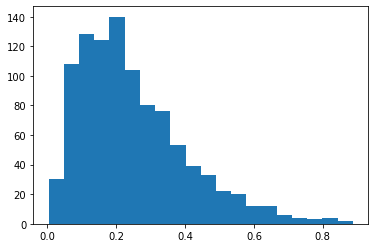

In [330]:
plt.hist(halo.radii,20)
print(halo.r_delta)

In [331]:
x = halo.radii*np.sin(halo.sphericalCoordinateAngles[0,:])*np.cos(halo.sphericalCoordinateAngles[1,:])
y = halo.radii*np.sin(halo.sphericalCoordinateAngles[0,:])*np.sin(halo.sphericalCoordinateAngles[1,:])
z = halo.radii*np.cos(halo.sphericalCoordinateAngles[0,:])

1.2131896729198106e-16

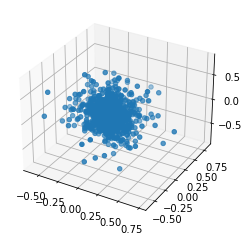

In [332]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
halo.virial_speed

In [333]:
halo.genTracers()

<ipython-input-327-0cd4f1b5a312>:102: RuntimeWarning: invalid value encountered in sqrt
  v_max = np.sqrt(2*self.nfwPotential(self.radii[i]))


ValueError: f(a) and f(b) must have different signs

In [ ]:
n=100
xlist = np.linspace(0,halo.r_delta,n)
ylist = []
print(xlist)
for i in range(n):
    ylist.append(halo.radialCDF(xlist[i]))
plt.plot(xlist,ylist)

In [155]:
np.zeros((3,2))
rng = default_rng()
default_rng().random()
A = np.array([2,3,4,5])
B = np.array([11,22,33,44])
C = np.array([A,B])

In [156]:
def test(x):
    return 2*x-1

def test_mod(x):
    return test(x) - default_rng().random(1)
optimize.root_scalar( test_mod, bracket = (-5,5) ).root

0.7577792502772075

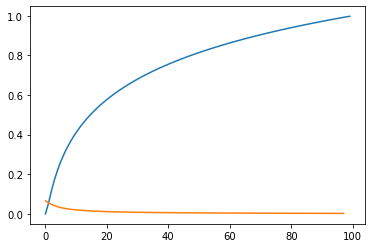

In [172]:
halo.radialCDF(.999*halo.r_delta)

CDF = []
PDF_est = []
for i in range(100):
    rad = (i/100)*halo.r_delta
    CDF.append(halo.radialCDF(rad))
    if i>1:
        PDF_est.append(CDF[i]-CDF[i-1])
    
plt.plot(CDF)
plt.plot(PDF_est)